In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.metrics import Precision, Recall, AUC, CategoricalAccuracy

from custom_models.augmentation import basic_plus_color_augmentation, basic_augmentation
from custom_models.bilinear_cnns import fe_resnet
from custom_models.cnns import simple_cnn_bn, base_resnet50
from custom_models.optimization_utilities import get_standard_callbacks
from etl.load_dataset import DatasetProcessor, get_tf_eggim_patch_dataset
from optimization.custom_losses import weighted_categorical_crossentropy

In [3]:
target_dir = '../../test_files/EGGIMazing/Dataset01'
model_weights_directory = '../../logs/'
batch_size = 32
num_epochs = 100
learning_rate = 1e-4
num_folds = 5
name = f'cv_embc2_patient_feresnet'
model_fold_dir = sorted(os.listdir(model_weights_directory))
model_dirs = [os.path.join(os.path.join(model_weights_directory, x), 'weights.h5')
              for x in model_fold_dir if x.startswith(name)]

In [4]:
model_dirs

['../../logs/cv_embc2_patient_feresnet_multi_26fold_0_20241111-115453/weights.h5',
 '../../logs/cv_embc2_patient_feresnet_multi_26fold_10_20241111-142701/weights.h5',
 '../../logs/cv_embc2_patient_feresnet_multi_26fold_11_20241111-144204/weights.h5',
 '../../logs/cv_embc2_patient_feresnet_multi_26fold_12_20241111-145712/weights.h5',
 '../../logs/cv_embc2_patient_feresnet_multi_26fold_13_20241111-151224/weights.h5',
 '../../logs/cv_embc2_patient_feresnet_multi_26fold_14_20241111-152725/weights.h5',
 '../../logs/cv_embc2_patient_feresnet_multi_26fold_15_20241111-154236/weights.h5',
 '../../logs/cv_embc2_patient_feresnet_multi_26fold_16_20241111-155748/weights.h5',
 '../../logs/cv_embc2_patient_feresnet_multi_26fold_17_20241111-161253/weights.h5',
 '../../logs/cv_embc2_patient_feresnet_multi_26fold_18_20241111-162820/weights.h5',
 '../../logs/cv_embc2_patient_feresnet_multi_26fold_19_20241111-164329/weights.h5',
 '../../logs/cv_embc2_patient_feresnet_multi_26fold_1_20241111-121002/weights

In [5]:
dp = DatasetProcessor(target_dir)
df = dp.process()
patient_ids = np.load('../../configs/test_patient_ids_2.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)


In [7]:
df_togas.to_csv('df_togas.csv')

In [9]:
!pwd

/home/miguelmartins/Projects/eggimazing/notebooks/multi_patient_wise


In [9]:
from sklearn.metrics import confusion_matrix

from evaluation.metrics import categorical_accuracy

from evaluation.metrics import specificity_per_class

from evaluation.metrics import sensitivity_per_class


metrics = []
y_true_ordinals = []
y_pred_ordinals = []
split = dp.patient_wise_split(df_togas,
                                      df_ipo,
                                      patient_ids,
                                      internal_train_size=0.9,
                                      target_variable='eggim_square',
                                      random_state=42)
for fold, (df_train, df_val, df_test) in enumerate(split):
    tf_test_df = get_tf_eggim_patch_dataset(df_test,
                                            num_classes=3,
                                            preprocess_fn=tf.keras.applications.resnet.preprocess_input)

    tf_test_df = tf_test_df.batch(batch_size)

    n_classes = 3  # Replace with the number of classes you have

    #
    model = base_resnet50(input_shape=(224, 224, 3), n_classes=n_classes)
    # Compile the model with Adam optimizer 13:21
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[CategoricalAccuracy(name='cat_accuracy'), Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc')])


    model.load_weights(model_dirs[fold])


    model = fe_resnet(input_shape=(224, 224, 3), n_classes=n_classes)
    # Compile the model with Adam optimizer 13:21
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[CategoricalAccuracy(name='cat_accuracy'), Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc')])


    model.load_weights(model_dirs[fold])

    y_true = np.concatenate([y for (_, y) in tf_test_df])
    y_pred = model.predict(tf_test_df)
    y_true_ordinal = np.argmax(y_true, axis=-1) # [0 0 1] -> 2
    y_pred_ordinal = np.argmax(y_pred, axis=-1)
    y_true_ordinals.append(y_true_ordinal)
    y_pred_ordinals.append(y_pred_ordinal)
    y_pred_one_hot = np.zeros_like(y_pred)
    y_pred_one_hot[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)] = 1 # [0.2, 0.2, 0.6] -> [0, 0, 1]
    conf_matrix = confusion_matrix(y_true_ordinal, y_pred_ordinal,
                                   labels=[0, 1, 2])
    metrics.append([categorical_accuracy(y_true, y_pred_one_hot),
                    specificity_per_class(conf_matrix), sensitivity_per_class(conf_matrix),
                    conf_matrix])

2024-11-13 11:58:36.790094: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-13 11:58:36.790406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-13 11:58:36.853835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

1/1 [==============================] - 1s 891ms/step


/home/miguelmartins/Projects/eggimazing/evaluation/metrics.py:28: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 1s/step


/home/miguelmartins/Projects/eggimazing/evaluation/metrics.py:28: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 959ms/step


/home/miguelmartins/Projects/eggimazing/evaluation/metrics.py:28: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 980ms/step


In [10]:
cat_acc = np.array([x[0] for x in metrics])
spec = np.array([x[1] for x in metrics])
sens = np.array([x[2] for x in metrics])
confs = np.array([x[3] for x in metrics], dtype=object)

In [11]:
spec

array([[0.66666667, 0.7       , 1.        ],
       [0.875     , 0.71428571, 0.85714286],
       [1.        , 0.625     , 0.9       ],
       [0.92307692, 0.58333333, 1.        ],
       [       nan, 1.        , 0.90909091],
       [1.        , 1.        , 1.        ],
       [0.8       , 1.        ,        nan],
       [1.        , 1.        , 0.5       ],
       [1.        , 1.        , 0.25      ],
       [0.84615385, 0.92307692,        nan],
       [1.        , 0.77777778, 0.88888889],
       [0.83333333, 0.8       , 1.        ],
       [0.72727273, 0.71428571, 0.83333333],
       [0.57142857, 1.        , 0.66666667],
       [1.        , 1.        , 0.75      ],
       [1.        , 1.        , 1.        ],
       [1.        , 0.90909091, 1.        ],
       [1.        , 0.8       , 1.        ],
       [1.        , 1.        , 0.8       ],
       [0.75      , 1.        , 1.        ],
       [1.        , 0.90909091, 1.        ],
       [0.85714286, 0.875     , 0.88888889],
       [1.

/tmp/ipykernel_3428036/639383448.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])


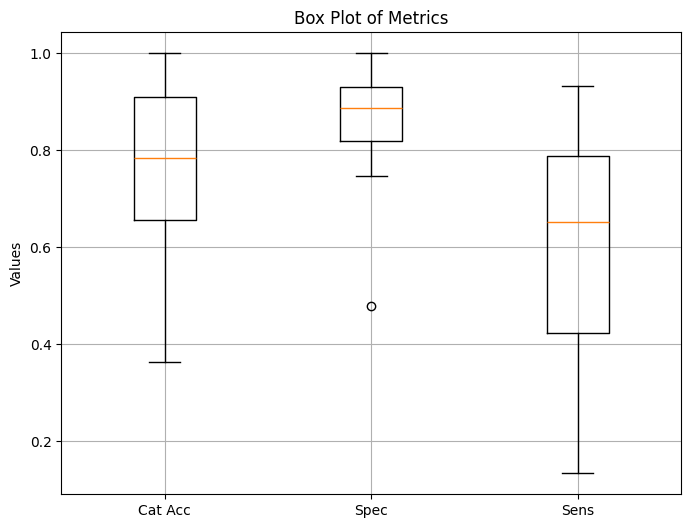

In [12]:
data = [cat_acc, np.nanmean(spec, axis=1), np.nanmean(sens, axis=1)]

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])
plt.title('Box Plot of Metrics')
plt.ylabel('Values')
plt.grid(True)

# Show the plot
plt.show()

In [13]:
data = np.array([cat_acc, np.nanmean(spec, axis=1), np.nanmean(sens, axis=1)])

In [14]:
data.shape

(3, 26)

In [15]:
np.mean(data, axis=1), np.std(data, axis=1)

(array([0.7674934 , 0.86386544, 0.60097499]),
 array([0.15491663, 0.10772861, 0.21968394]))

In [16]:
from evaluation.eggim import *
def replace_landmark_name(landmark):
    new_landmark_name = {'ii': 'distal body',
                    'ix': 'distal lc',
                    'vi': 'proximal ant lc',
                    'vii': 'proximal ant gc/pw',
                    'viii': 'incisura r',
                    'x': 'upper body r',
                    'xii': 'upper body ant'}
    landmark_number = landmark.split('.')[0]
    return new_landmark_name[landmark_number]

dp = DatasetProcessor(target_dir)
df = dp.process()
df['landmark'] = df['landmark'].apply(replace_landmark_name)
patient_ids = np.load('../../configs/test_patient_ids_2.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)


In [17]:
df_ipo

,bbox,eggim_global,eggim_square,landmark,image_directory,patient_id
0,"[221, 135, 445, 359]",1,1,distal lc,../../test_files/EGGIMazing/Dataset01/20190927...,2019092708
1,"[147, 176, 371, 400]",0,0,incisura r,../../test_files/EGGIMazing/Dataset01/20190927...,2019092710
2,"[226, 216, 449, 440]",2,2,incisura r,../../test_files/EGGIMazing/Dataset01/20190927...,2019092711
3,"[198, 130, 422, 355]",2,2,incisura r,../../test_files/EGGIMazing/Dataset01/20190930...,2019093009
4,"[208, 142, 432, 365]",2,2,proximal ant gc/pw,../../test_files/EGGIMazing/Dataset01/20190930...,2019093009
...,...,...,...,...,...,...
408,"[222, 176, 446, 401]",2,2,proximal ant lc,../../test_files/EGGIMazing/Dataset01/20211008...,2021100811
409,"[198, 43, 422, 268]",2,2,incisura r,../../test_files/EGGIMazing/Dataset01/20211029...,2021102911
410,"[191, 138, 415, 362]",0,0,distal lc,../../test_files/EGGIMazing/Dataset01/20211029...,2021102911
411,"[184, 45, 408, 269]",2,2,proximal ant lc,../../test_files/EGGIMazing/Dataset01/20220314...,2022031408


In [18]:
def compute_eggim_patient(patient_df, target_variable):
    df = patient_df[['landmark', target_variable]].value_counts()
    # we use index[0] to assume first landmark/score pair is correct
    eggim_antrum_incisura = df['proximal ant lc'].index[0] + df['proximal ant gc/pw'].index[0] + df['incisura r'].index[0]
    eggim_body_1 = (df['distal body'].index[0] + df['upper body ant'].index[0]) / 2
    eggim_body_2 = (df['distal lc'].index[0]+ df['upper body r'].index[0]) / 2
    return eggim_antrum_incisura + eggim_body_1 + eggim_body_2

eggim_scores = {}
for i, patient_id in enumerate(patient_ids):
    print(patient_id)
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    df_patient['pred'] = y_pred_ordinals[i]
    eggim_square = compute_eggim_patient(df_patient,
                                          target_variable='eggim_square')
    eggim_global = compute_eggim_patient(df_patient,
                                  target_variable='eggim_global')
    eggim_pred = compute_eggim_patient(df_patient,
                                  target_variable='pred')
    eggim_scores[patient_ids[i]] = {'eggim_square': eggim_square, 'eggim_global': eggim_global,
                                    'eggim_pred': eggim_pred}
eggim_df = pd.DataFrame(eggim_scores).T

PT004
PT005
PT006
PT009
PT016
PT020
PT021
PT022
PT024
PT025
PT028
PT029
PT030
PT031
PT034
PT035
PT037
PT039
PT040
PT041
PT045
PT046
PT048
PT049
PT051
PT053


/tmp/ipykernel_3428036/760769985.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_pred_ordinals[i]
/tmp/ipykernel_3428036/760769985.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_pred_ordinals[i]
/tmp/ipykernel_3428036/760769985.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [19]:
eggim_df

,eggim_square,eggim_global,eggim_pred
PT004,1.0,1.0,2.0
PT005,4.0,3.0,3.0
PT006,1.0,1.0,2.5
PT009,8.0,8.5,5.5
PT016,0.0,0.0,0.0
PT020,1.0,2.0,1.0
PT021,10.0,10.0,8.0
PT022,8.0,8.0,9.0
PT024,7.0,7.0,9.0
PT025,10.0,10.0,8.0


In [ ]:
eggim_df.to_csv('feresnet_embc.csv')

In [ ]:
print(os.getcwd())

In [ ]:
# minimum error of patch vs global labels
best_possible_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 0]))

In [9]:
# error of patch predictions vs patch labels
patch_eggim_mae =  np.mean(np.abs(eggim_df.iloc[:, 0] -  eggim_df.iloc[:, 2]))

In [13]:
patch_global_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 2]))

In [11]:
patch_eggim_mae

1.4038461538461537

In [ ]:
# patch ground truth vs patch pred:
patch_eggim_mae

In [14]:
# global ground truth vs patch pred
patch_global_eggim_mae

1.4615384615384615

In [ ]:
# global ground truth vs patch pred "adjusted" with minimum error in square labels
patch_global_eggim_mae - best_possible_eggim_mae